In [4]:
!pip install -q pyDOE

In [241]:
from pyDOE import lhs
from statistics import median
import copy as cp
import numpy.matlib as npm
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
import time
from tqdm import tqdm
import pickle  # To save and load results
import os
from collections import Counter
import multiprocessing as mp
from multiprocessing import Pool
import scipy.stats as stats

# PyCX Predator Prey Model

Adapted from Hiroki Sayama's PyCX module. For more information about the model, please see Sections 4.6 and 19.4 of Sayama’s book (Introduction to the Modeling and Analysis of Complex Systems).

### Load needed packages

Below includes an example of how to install and load `pyDOE` for Latin hypercube sampling.

#### part a)

In [2]:
''' model parameters '''

nr = 500. # carrying capacity of rabbits ***

r_init = 100 # initial rabbit population
mr = 0.03 # magnitude of movement of rabbits
dr = 1.0 # death rate of rabbits when it faces foxes ***
rr = 0.1 # reproduction rate of rabbits

f_init = 30 # initial fox population
mf = 0.1 # magnitude of movement of foxes
df = 0.025 # death rate of foxes when there is no food ***
rf = 0.5 # reproduction rate of foxes ***

cd = 0.02 # radius for collision detection
cdsq = cd ** 2

In [3]:
''' model functions '''

class agent:
    pass

def initialize():
    global agents, rdata, fdata
    agents = []
    rdata = []
    fdata = []
    for i in range(r_init + f_init):
        ag = agent()
        ag.type = 'r' if i < r_init else 'f'
        ag.x = random.random()
        ag.y = random.random()
        agents.append(ag)

def observe():
    global agents, rdata, fdata

    plt.subplot(2, 1, 1)
    plt.cla()
    rabbits = [ag for ag in agents if ag.type == 'r']
    if len(rabbits) > 0:
        x = [ag.x for ag in rabbits]
        y = [ag.y for ag in rabbits]
        plt.plot(x, y, 'b.')
    foxes = [ag for ag in agents if ag.type == 'f']
    if len(foxes) > 0:
        x = [ag.x for ag in foxes]
        y = [ag.y for ag in foxes]
        plt.plot(x, y, 'ro')
    plt.axis('image')
    plt.axis([0, 1, 0, 1])

    plt.subplot(2, 1, 2)
    plt.cla()
    plt.plot(rdata, label = 'prey', color = 'blue')
    plt.plot(fdata, label = 'predator', color = 'red')
    plt.legend()

def update():
    global agents, rdata, fdata
    t = 0.
    while t < 1. and len(agents) > 0:
        t += 1. / len(agents)
        update_one_agent()

    rdata.append(sum([1 for x in agents if x.type == 'r']))
    fdata.append(sum([1 for x in agents if x.type == 'f']))

def update_one_agent():
    global agents
    if agents == []:
        return

    ag = random.choice(agents)

    # simulating random movement
    m = mr if ag.type == 'r' else mf
    ag.x += random.uniform(-m, m)
    ag.y += random.uniform(-m, m)
    ag.x = 1 if ag.x > 1 else 0 if ag.x < 0 else ag.x
    ag.y = 1 if ag.y > 1 else 0 if ag.y < 0 else ag.y

    # detecting collision and simulating death or birth
    neighbors = [nb for nb in agents if nb.type != ag.type
                 and (ag.x - nb.x)**2 + (ag.y - nb.y)**2 < cdsq]

    if ag.type == 'r':
        if len(neighbors) > 0: # if there are foxes nearby
            if random.random() < dr:
                agents.remove(ag)
                return
        if random.random() < rr*(1-sum([1 for x in agents if x.type == 'r'])/nr):
            agents.append(cp.copy(ag))
    else:
        if len(neighbors) == 0: # if there are no rabbits nearby
            if random.random() < df:
                agents.remove(ag)
                return
        else: # if there are rabbits nearby
            if random.random() < rf:
                agents.append(cp.copy(ag))

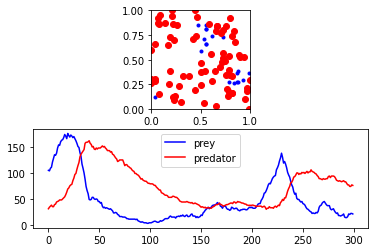

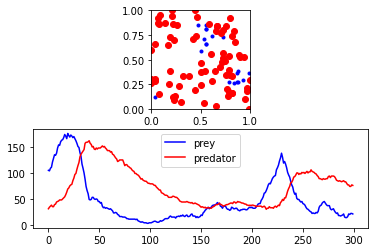

In [4]:
#part a)
timesteps = 300

initialize()
for i in range(timesteps):
    update()
    observe()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.0001)

#### part b)

In [5]:
def update_one_agent():
    global agents
    if not agents:
        return
        
    ag = random.choice(agents)
    
    # Random movement
    m = mr if ag.type == 'r' else mf
    ag.x += random.uniform(-m, m)
    ag.y += random.uniform(-m, m)
    ag.x = min(1, max(0, ag.x))
    ag.y = min(1, max(0, ag.y))
    
    # Detect collision and simulate birth/death
    neighbors = [nb for nb in agents if nb.type != ag.type
                and (ag.x - nb.x) ** 2 + (ag.y - nb.y) ** 2 < cdsq]
    
    if ag.type == 'r':  # Rabbit logic
        if neighbors and random.random() < dr:
            agents.remove(ag)
            return
        if random.random() < rr * (1 - sum(1 for x in agents if x.type == 'r') / nr):
            agents.append(cp.copy(ag))
    else:  # Fox logic
        if not neighbors and random.random() < df:
            agents.remove(ag)
            return
        if neighbors and random.random() < rf:
            agents.append(cp.copy(ag))

# Update all agents
def update():
    n = len(agents)
    for _ in range(n):
        update_one_agent()
        

In [6]:
#filename = "pred_prey.pkl"
#try:
#    with open(filename, "wb") as f:
#        pickle.dump(data, f)
#    print(f"Data successfully saved to {filename}.")
#except Exception as e:
#    print(f"Error saving data to {filename}: {e}")


def load_data(filename="pred_prey.pkl"):
    """Load data from the pickle file, returning a dictionary."""
    if os.path.exists(filename) and os.path.getsize(filename) > 0:
        try:
            with open(filename, "rb") as f:
                data = pickle.load(f)
                if isinstance(data, list):
                    # Convert list to dictionary if stored as list
                    return {i: sim for i, sim in enumerate(data)}
                return data
        except (EOFError, pickle.UnpicklingError):
            print(f"Warning: {filename} is corrupted or empty. Resetting.")
            return {}
    return {}

def save_simulation(sim_idx, sim_data, filename="pred_prey.pkl"):
    data_dict = load_data(filename)
    data_dict[sim_idx] = sim_data
    try:
        with open(filename, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Simulation {sim_idx} saved.")
    except Exception as e:
        print(f"Error saving simulation {sim_idx}: {e}")
    return len(data_dict)

def run_simulations(total_runs=10000, timesteps=400, filename="pred_prey.pkl"):
    data_dict = load_data(filename)
    start_idx = max(data_dict.keys()) + 1 if data_dict else 0
    
    for run in tqdm(range(start_idx, total_runs)):
        initialize()  # Make sure this function is defined
        sim_data = []
        
        for i in range(timesteps):
            update()  # Make sure this function is defined
            
            # Count rabbits and foxes (assuming `agents` is a list of agent objects)
            agent_types = [ag.type for ag in agents]  # Assuming `agents` is defined
            num_rabbits = agent_types.count('r')
            num_foxes = agent_types.count('f')
            
            sim_data.append((num_rabbits, num_foxes))
        
        # Save after each simulation
        total_sims = save_simulation(run, sim_data, filename)
        print(f"Simulation {run} complete. Total simulations: {total_sims}/{total_runs}")

def run_single_simulation(timesteps=400):
    initialize()  # Make sure this function is defined
    sim_data = []
    
    for i in range(timesteps):
        update()  # Make sure this function is defined
        
        # Count rabbits and foxes (assuming `agents` is a list of agent objects)
        agent_types = [ag.type for ag in agents]  # Assuming `agents` is defined
        num_rabbits = agent_types.count('r')
        num_foxes = agent_types.count('f')
        
        sim_data.append((num_rabbits, num_foxes))
        
    return sim_data
timesteps = 400

# Execute a single simulation
if __name__ == "__main__":
    timesteps = 400
    sim_data = run_single_simulation(timesteps)
    print(f"Final populations - Rabbits: {sim_data[-1][0]}, Foxes: {sim_data[-1][1]}")
    
    # To run multiple simulations:
    run_simulations(total_runs = 10, timesteps=400)


Final populations - Rabbits: 0, Foxes: 26


0it [00:00, ?it/s]


In [7]:
with open("pred_prey.pkl", "rb") as f:
    pred_prey = pickle.load(f)

number of simulations ran: 10


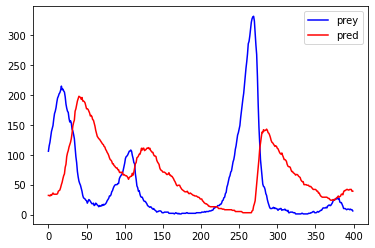

In [10]:
### plot all of the simulations over one another
num_keys = len(pred_prey)
print(f'number of simulations ran: {num_keys}')

timesteps = 400

sims = []
sim_prey, sim_pred = [], []
for key in range(num_keys):
    sim = pred_prey[key]
    simi_prey, simi_pred = [x for x, y in sim], [y for x, y in sim]
    sim_prey.append(simi_prey)
    sim_pred.append(simi_pred)
    
sim1 = pred_prey[0]
sim1_prey, sim1_pred = [x for x, y in sim1], [y for x, y in sim1]

    
plt.plot(range(timesteps), sim1_prey, label = 'prey', color = 'blue')
plt.plot(range(timesteps), sim1_pred, label = 'pred', color = 'red')
plt.legend(loc = 'best')

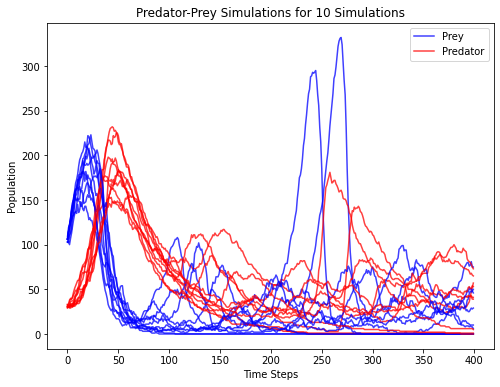

In [12]:
timesteps = 400
plt.figure(figsize=(8, 6))  

for i in range(num_keys):
    plt.plot(range(timesteps), sim_prey[i], color='blue', alpha=0.75)  # Prey
    plt.plot(range(timesteps), sim_pred[i], color='red', alpha=0.75)   # Predator

# Add labels and legend
plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.title(f"Predator-Prey Simulations for {len(range(num_keys))} Simulations")
plt.legend(["Prey", "Predator"], loc='best')

#### part c)

In [199]:
filename = "pred_prey_nr.pkl"
try:
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    print(f"Data successfully saved to {filename}.")
except Exception as e:
    print(f"Error saving data to {filename}: {e}")


Error saving data to pred_prey_nr.pkl: name 'data' is not defined


In [206]:
r_init = 100 # initial rabbit population
mr = 0.03 # magnitude of movement of rabbits
dr = 1.0 # death rate of rabbits when it faces foxes ***
rr = 0.1 # reproduction rate of rabbits

f_init = 30 # initial fox population
mf = 0.1 # magnitude of movement of foxes
df = 0.025 # death rate of foxes when there is no food ***
rf = 0.5 # reproduction rate of foxes ***

cd = 0.02 # radius for collision detection
cdsq = cd ** 2

nr_values = [200, 300, 400, 500, 600, 700, 800]
nr = nr_values[6]

filename = "pred_prey_nr.pkl"

def load_data(filename = filename):
    """Load data from the pickle file, returning a dictionary."""
    if os.path.exists(filename) and os.path.getsize(filename) > 0:
        try:
            with open(filename, "rb") as f:
                data = pickle.load(f)
                if isinstance(data, list):
                    # Convert list to dictionary if stored as list
                    return {i: sim for i, sim in enumerate(data)}
                return data
        except (EOFError, pickle.UnpicklingError):
            print(f"Warning: {filename} is corrupted or empty. Resetting.")
            return {}
    return {}

def initialize():
    global agents, rdata, fdata
    agents = []
    rdata = []
    fdata = []
    for i in range(r_init + f_init):
        ag = agent()
        ag.type = 'r' if i < r_init else 'f'
        ag.x = random.random()
        ag.y = random.random()
        agents.append(ag)

    
def run_simulations(params, nsamples, reruns, timesteps=400, filename=filename):
    data_dict = load_data(filename)
    start_idx = max(data_dict.keys()) + 1 if data_dict else 0  

    for i in range(nsamples * reruns):
        nr = params[i, 0] * (800 - 200) + 200  # Carrying capacity for rabbits
        dr = params[i, 1]  # Death probability for rabbits when encountering foxes
        df = params[i, 2]  # Death probability for foxes when no food is available
        rf = params[i, 3]  # Reproduction probability for foxes when food is available

        print(f"Run {start_idx + i}: nr={nr:.0f}, dr={dr:.3f}, df={df:.3f}, rf={rf:.3f}")

        initialize(nr)  
        sim_data = []

        for t in range(timesteps):
            update()  
            agent_types = [ag.type for ag in agents]  
            num_rabbits = agent_types.count('r')
            num_foxes = agent_types.count('f')
            sim_data.append((num_rabbits, num_foxes))
        
        final_pop_prey.append(sim_data[-1][0])
        final_pop_pred.append(sim_data[-1][1])

        total_sims = save_simulation(start_idx + i, sim_data, filename)
        print(f"Simulation {start_idx + i} complete. Total simulations so far: {total_sims}")

    print(f"Completed {nsamples * reruns} additional simulations. Total simulations in file: {total_sims}")
    return params, final_pop_prey, final_pop_pred


# Execute a single simulation
if __name__ == "__main__":
    timesteps = 400
    sim_data = run_single_simulation(timesteps)
    
    # To run multiple simulations:
    run_simulations(timesteps = 400)
    
num_keys_nr = len(pred_prey_nr)
print(f'number of simulations ran: {num_keys_nr}')

Final populations - Rabbits: 34, Foxes: 70
Simulation 60 complete. Total simulations so far: 61
Final populations - Rabbits: 0, Foxes: 0
Simulation 61 complete. Total simulations so far: 62
Final populations - Rabbits: 0, Foxes: 0
Simulation 62 complete. Total simulations so far: 63
Final populations - Rabbits: 0, Foxes: 0
Simulation 63 complete. Total simulations so far: 64
Final populations - Rabbits: 12, Foxes: 57
Simulation 64 complete. Total simulations so far: 65
Final populations - Rabbits: 0, Foxes: 0
Simulation 65 complete. Total simulations so far: 66
Final populations - Rabbits: 0, Foxes: 0
Simulation 66 complete. Total simulations so far: 67
Final populations - Rabbits: 0, Foxes: 0
Simulation 67 complete. Total simulations so far: 68
Final populations - Rabbits: 12, Foxes: 75
Simulation 68 complete. Total simulations so far: 69
Final populations - Rabbits: 48, Foxes: 118
Simulation 69 complete. Total simulations so far: 70
Completed 10 additional simulations. Total simulati

In [207]:
filename = "pred_prey_nr.pkl"
with open(filename, "rb") as f:
    pred_prey_nr = pickle.load(f)


if os.path.exists(filename):
    if os.path.getsize(filename) == 0:
        print("The file is empty!")
    else:
        print(f"The file size is {os.path.getsize(filename)} bytes.")
else:
    print("File does not exist.")

The file size is 168498 bytes.


In [208]:
sims_nr = []
sim_prey_nr, sim_pred_nr = [], []

keys = list(pred_prey_nr.keys()) 

for i in range(0, len(keys), 10):
    subset_keys = keys[i:i+10] 
    subset = [pred_prey_nr[k] for k in subset_keys]  

    sim_nr = np.mean(subset, axis=0)
    simi_prey_nr, simi_pred_nr = zip(*sim_nr)

    sim_prey_nr.append(list(simi_prey_nr))
    sim_pred_nr.append(list(simi_pred_nr))

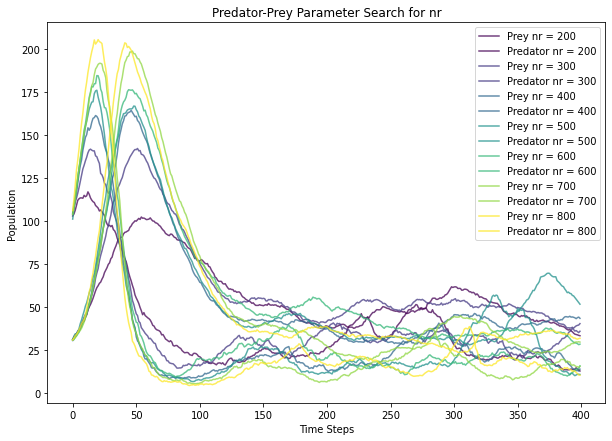

In [209]:
plt.figure(figsize=(10, 7))  

nr_values = [200, 300, 400, 500, 600, 700, 800]

num_sims = len(sim_prey_nr) 
colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

for i in range(num_sims):  
    plt.plot(range(timesteps), sim_prey_nr[i], color = colors[i], alpha=0.75, label=f"Prey nr = {nr_values[i]}")  # Prey
    plt.plot(range(timesteps), sim_pred_nr[i], color = colors[i], alpha=0.75, label=f"Predator nr = {nr_values[i]}")   # Predator

# Add labels and legend
plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.title(f"Predator-Prey Parameter Search for nr")
plt.legend(loc='best')

#### part d and e)

In [270]:
filename = "pred_prey_paramsweep.pkl"
try:
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    print(f"Data successfully saved to {filename}.")
except Exception as e:
    print(f"Error saving data to {filename}: {e}")


Error saving data to pred_prey_paramsweep.pkl: name 'data' is not defined


Run 0: nr=747, dr=0.829, df=0.601, rf=0.771
Simulation 0 complete. Total simulations so far: 1
Run 1: nr=747, dr=0.829, df=0.601, rf=0.771
Simulation 1 complete. Total simulations so far: 2
Run 2: nr=331, dr=0.131, df=0.369, rf=0.563
Simulation 2 complete. Total simulations so far: 3
Run 3: nr=331, dr=0.131, df=0.369, rf=0.563
Simulation 3 complete. Total simulations so far: 4
Run 4: nr=223, dr=0.231, df=0.292, rf=0.922
Simulation 4 complete. Total simulations so far: 5
Run 5: nr=223, dr=0.231, df=0.292, rf=0.922
Simulation 5 complete. Total simulations so far: 6
Run 6: nr=432, dr=0.628, df=0.458, rf=0.809
Simulation 6 complete. Total simulations so far: 7
Run 7: nr=432, dr=0.628, df=0.458, rf=0.809
Simulation 7 complete. Total simulations so far: 8
Run 8: nr=464, dr=0.012, df=0.311, rf=0.680
Simulation 8 complete. Total simulations so far: 9
Run 9: nr=464, dr=0.012, df=0.311, rf=0.680
Simulation 9 complete. Total simulations so far: 10
Run 10: nr=528, dr=0.197, df=0.395, rf=0.469
Simu

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

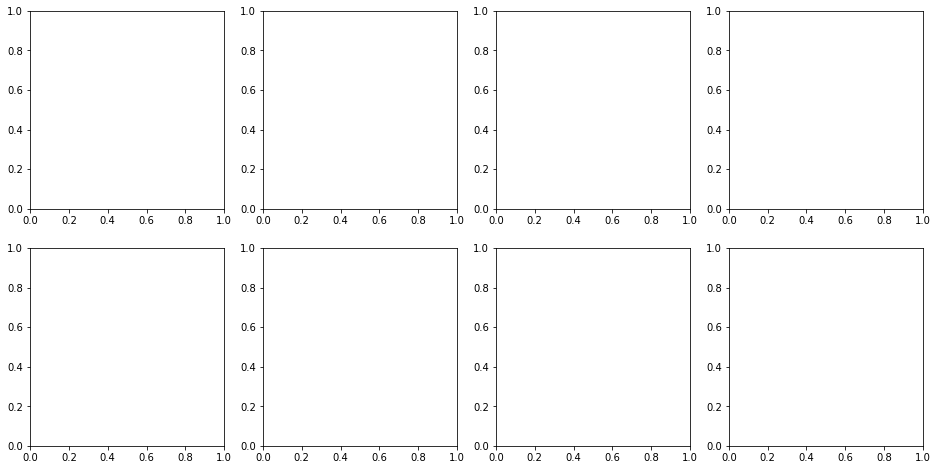

In [272]:
filename = "pred_prey_paramsweep.pkl"

def load_data(filename=filename):
    """Load data from the pickle file, returning a dictionary."""
    if os.path.exists(filename) and os.path.getsize(filename) > 0:
        try:
            with open(filename, "rb") as f:
                data = pickle.load(f)
                if isinstance(data, list):
                    return {i: sim for i, sim in enumerate(data)}
                return data
        except (EOFError, pickle.UnpicklingError):
            print(f"Warning: {filename} is corrupted or empty. Resetting.")
            return {}
    return {}

def save_simulation(run, sim_data, filename):
    """Save simulation data to file."""
    data_dict = load_data(filename)
    data_dict[run] = sim_data
    with open(filename, "wb") as f:
        pickle.dump(data_dict, f)
    return len(data_dict)

def initialize(nr):
    """Initialize agent population with given carrying capacity for rabbits."""
    global agents, rdata, fdata, r_init, f_init
    agents = []
    rdata = []
    fdata = []
    
    r_init = int(nr)  # Set initial rabbit population based on carrying capacity
    f_init = 50       # Adjust fox population as needed

    for i in range(r_init + f_init):
        ag = agent()
        ag.type = 'r' if i < r_init else 'f'
        ag.x = random.random()
        ag.y = random.random()
        agents.append(ag)

final_pop_pred, final_pop_prey = [], []


def run_simulations(params, nsamples, reruns, timesteps=400, filename=filename):
    data_dict = load_data(filename)
    start_idx = max(data_dict.keys()) + 1 if data_dict else 0  

    final_pop_prey = []
    final_pop_pred = []

    for i in range(nsamples * reruns):
        nr = params[i, 0] * (800 - 200) + 200  # Carrying capacity for rabbits
        dr = params[i, 1]  # Death probability for rabbits when encountering foxes
        df = params[i, 2]  # Death probability for foxes when no food is available
        rf = params[i, 3]  # Reproduction probability for foxes when food is available

        print(f"Run {start_idx + i}: nr={nr:.0f}, dr={dr:.3f}, df={df:.3f}, rf={rf:.3f}")

        initialize(nr)  
        sim_data = []

        for t in range(timesteps):
            update()  
            agent_types = [ag.type for ag in agents]  
            num_rabbits = agent_types.count('r')
            num_foxes = agent_types.count('f')
            sim_data.append((num_rabbits, num_foxes))
        
        final_pop_prey.append(sim_data[-1][0])
        final_pop_pred.append(sim_data[-1][1])

        total_sims = save_simulation(start_idx + i, sim_data, filename)
        print(f"Simulation {start_idx + i} complete. Total simulations so far: {total_sims}")

    print(f"Completed {nsamples * reruns} additional simulations. Total simulations in file: {total_sims}")
    return params, final_pop_prey, final_pop_pred


def plot_scatterplots(params, final_prey, final_pred):
    """Generate scatterplots for each parameter vs. final prey and predator populations."""
    param_names = ["Carrying Capacity (nr)", "Rabbit Death Prob. (dr)", "Fox Death Prob. (df)", "Fox Reproduction Prob. (rf)"]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(params)))
    
    for i in range(4):
        axes[0, i].scatter(params[:, i], final_prey, alpha=0.6, color = colors[:, i])
        axes[0, i].set_xlabel(param_names[i])
        axes[0, i].set_ylabel("Final Prey Population")
        axes[0, i].set_title(f"{param_names[i]} vs. Final Prey")
        
        axes[1, i].scatter(params[:, i], final_pred, alpha=0.6, color = colors[:,i])
        axes[1, i].set_xlabel(param_names[i])
        axes[1, i].set_ylabel("Final Predator Population")
        axes[1, i].set_title(f"{param_names[i]} vs. Final Predators")
    
    plt.tight_layout()

if __name__ == "__main__":
    timesteps, nsamples, reruns, nparams = 400, 100, 2, 4
    params = lhs(nparams, samples=nsamples)
    params = np.repeat(params, reruns, axis=0)
    
    params, final_prey, final_pred = run_simulations(params, nsamples, reruns, timesteps)
    plot_scatterplots(params, final_prey, final_pred)
    
    num_keys_params = len(load_data(filename))
    print(f'Number of simulations ran: {num_keys_params}')

In [261]:
final_pop_prey = np.array(final_pop_prey)
final_pop_pred = np.array(final_pop_pred)

print(f"params shape: {params.shape}")  # Should be (200, 4)
print(f"final_pop_prey shape: {final_pop_prey.shape}")  # Should be (200,)
print(f"final_pop_pred shape: {final_pop_pred.shape}")  # Should be (200,)


for i in range(params.shape[1]):
    corr_prey, _ = stats.pearsonr(params[:, i], final_pop_prey)
    corr_pred, _ = stats.pearsonr(params[:, i], final_pop_pred)
    print(f"Parameter {i}: Correlation with prey = {corr_prey:.3f}, with predator = {corr_pred:.3f}")

params shape: (200, 4)
final_pop_prey shape: (0,)
final_pop_pred shape: (0,)


ValueError: x and y must have the same length.

In [262]:
filename = "pred_prey_paramsweep.pkl"
with open(filename, "rb") as f:
    pred_prey_params = pickle.load(f)


if os.path.exists(filename):
    if os.path.getsize(filename) == 0:
        print("The file is empty!")
    else:
        print(f"The file size is {os.path.getsize(filename)} bytes.")
else:
    print("File does not exist.")

The file size is 487629 bytes.


In [266]:
sims_params = []
sim_prey_params, sim_pred_params = [], []
total_prey, total_pred = [], []
keys = list(pred_prey_params.keys()) 
print(len(keys))

for i in range(0, len(keys)):
    simi_prey_params, simi_pred_params = zip(*sim_params)

    sim_prey_params.append(list(simi_prey_params))
    sim_pred_params.append(list(simi_pred_params))
    
    total_prey.append(sum(simi_prey_params))  
    total_pred.append(sum(simi_pred_params)) 
    

200


Text(0.5, 1.0, 'Final Prey vs Predator Populations for Each Simulation')

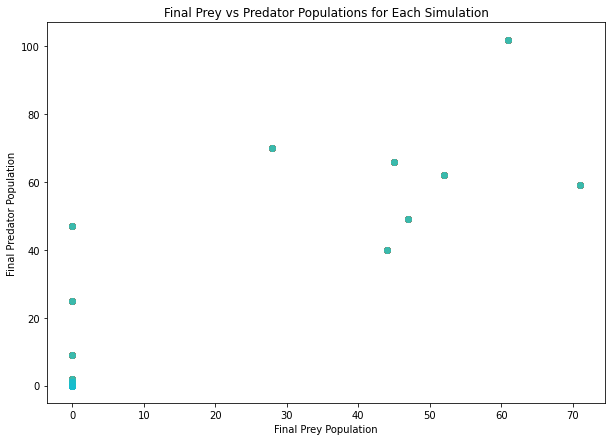

In [265]:
plt.figure(figsize=(10, 7))

# Scatter plot of final prey vs. predator populations
for i in range(len(keys)):
    plt.scatter(final_pop_prey1, final_pop_pred1, alpha=0.75)  # Adjust color as needed

# Add labels, title, and legend
plt.xlabel("Final Prey Population")
plt.ylabel("Final Predator Population")
plt.title("Final Prey vs Predator Populations for Each Simulation")

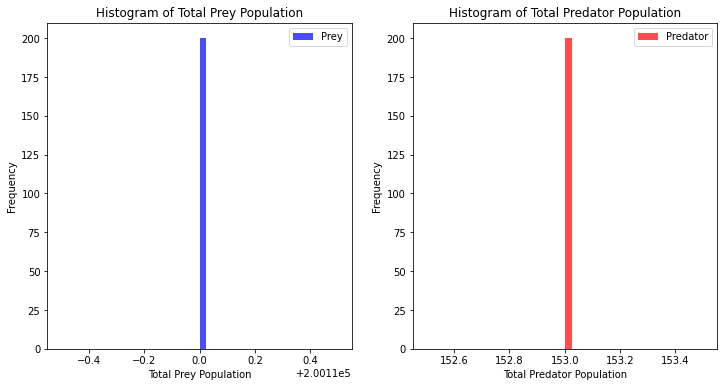

In [267]:
plt.figure(figsize=(12, 6))

# Histogram for prey population
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(total_prey, bins=40, color='blue', alpha=0.7, label='Prey')
plt.xlabel("Total Prey Population")
plt.ylabel("Frequency")
plt.title("Histogram of Total Prey Population")
plt.legend()

# Histogram for predator population
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(total_pred, bins=40, color='red', alpha=0.7, label='Predator')
plt.xlabel("Total Predator Population")
plt.ylabel("Frequency")
plt.title("Histogram of Total Predator Population")
plt.legend(loc = 'best')